In [4]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import itertools
import time

from torch.utils.data import DataLoader
from torch import nn
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error

sys.path.append("..")
from utils import metrics
from utils.data import TimeFusionDataset
from timefusion import TimeFusion
from utils.early_stopper import EarlyStopper

In [5]:
# Import data
train_data = pd.read_csv("../../datasets/exchange/train.csv")
val_data = pd.read_csv("../../datasets/exchange/val.csv")
test_data = pd.read_csv("../../datasets/exchange/test.csv")

train_data.index = list(range(train_data.shape[0]))
val_data.index = list(range(train_data.shape[0], train_data.shape[0] + val_data.shape[0]))
test_data.index = list(range(train_data.shape[0] + val_data.shape[0], train_data.shape[0] + val_data.shape[0] + test_data.shape[0]))

# Normalize the signal power of each column
stds = train_data.std()
train_data /= stds
val_data /= stds
test_data /= stds

# Concatenate to get full data
full_data = pd.concat([train_data,val_data,test_data])

In [6]:
# Compute device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

In [7]:
context_length = 30
prediction_length = 30

def get_data_loader(data, context_length):

    dataset = TimeFusionDataset(
        data = data,
        context_length = context_length,
    )

    dataloader = DataLoader(
        dataset = dataset,
        shuffle = True,
        num_workers = 3,
        batch_size = 128,
    )

    return dataloader, dataset

train_loader, train_dataset = get_data_loader(train_data, context_length)
val_loader, val_dataset = get_data_loader(val_data, context_length)
test_loader, test_dataset = get_data_loader(test_data, context_length)

In [8]:
rnn_hidden = int(0.5*train_data.shape[1])
residual_hidden = int((rnn_hidden + train_data.shape[1])*2)

predictor = TimeFusion(
    input_size = train_dataset.data.shape[1],
    output_size = train_data.shape[1],
    rnn_layers = 2,
    rnn_hidden = rnn_hidden,
    residual_layers = 8,
    residual_hidden = residual_hidden,
    dropout = 0,
    scaling = True,
    device = device,
    residual_scaler = True
)

print("Number of trainable parameters:",sum(p.numel() for p in predictor.parameters()))

/rds/general/user/ejh19/home/Final-Year-Project/timefusion/examples/../utils/diffusion.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.bar_alphas = torch.tensor(


Number of trainable parameters: 6424


In [9]:
optimizer = torch.optim.Adam(params=predictor.parameters(), lr=1e-3, weight_decay=0)
lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.001, total_iters=200)

predictor.train_network(
    train_loader = train_loader,
    epochs=200,
    val_loader = val_loader,
    optimizer = optimizer,
    lr_scheduler= lr_scheduler,
    early_stopper=EarlyStopper(patience=200),
    disable_progress_bar = False,
    save_weights = True
)

Epoch: 1/200: 100%|██████████| 48/48 [00:01<00:00, 33.38batch/s, Training loss=1.0035]


val_loss: 0.9594 , 


Epoch: 2/200: 100%|██████████| 48/48 [00:00<00:00, 76.81batch/s, Training loss=0.9192] 


val_loss: 0.8095 , 


Epoch: 3/200: 100%|██████████| 48/48 [00:00<00:00, 78.81batch/s, Training loss=0.6741] 


val_loss: 0.5641 , 


Epoch: 4/200: 100%|██████████| 48/48 [00:00<00:00, 78.55batch/s, Training loss=0.5204] 


val_loss: 0.4878 , 


Epoch: 5/200: 100%|██████████| 48/48 [00:00<00:00, 77.91batch/s, Training loss=0.4610] 


val_loss: 0.4139 , 


Epoch: 6/200: 100%|██████████| 48/48 [00:00<00:00, 71.49batch/s, Training loss=0.3956] 


val_loss: 0.3594 , 


Epoch: 7/200: 100%|██████████| 48/48 [00:00<00:00, 70.34batch/s, Training loss=0.3281]


val_loss: 0.2832 , 


Epoch: 8/200: 100%|██████████| 48/48 [00:00<00:00, 71.42batch/s, Training loss=0.2653] 


val_loss: 0.2509 , 


Epoch: 9/200: 100%|██████████| 48/48 [00:00<00:00, 71.36batch/s, Training loss=0.2507] 


val_loss: 0.2560 , 


Epoch: 10/200: 100%|██████████| 48/48 [00:00<00:00, 72.43batch/s, Training loss=0.2352] 


val_loss: 0.2264 , 


Epoch: 11/200: 100%|██████████| 48/48 [00:00<00:00, 75.28batch/s, Training loss=0.2243] 


val_loss: 0.2155 , 


Epoch: 12/200: 100%|██████████| 48/48 [00:00<00:00, 78.86batch/s, Training loss=0.2203] 


val_loss: 0.2164 , 


Epoch: 13/200: 100%|██████████| 48/48 [00:00<00:00, 74.88batch/s, Training loss=0.2177]


val_loss: 0.2082 , 


Epoch: 14/200: 100%|██████████| 48/48 [00:00<00:00, 74.66batch/s, Training loss=0.2023] 


val_loss: 0.1973 , 


Epoch: 15/200: 100%|██████████| 48/48 [00:00<00:00, 76.99batch/s, Training loss=0.1866] 


val_loss: 0.1742 , 


Epoch: 16/200: 100%|██████████| 48/48 [00:00<00:00, 75.82batch/s, Training loss=0.1544] 


val_loss: 0.1487 , 


Epoch: 17/200: 100%|██████████| 48/48 [00:00<00:00, 78.30batch/s, Training loss=0.1262] 


val_loss: 0.1170 , 


Epoch: 18/200: 100%|██████████| 48/48 [00:00<00:00, 78.84batch/s, Training loss=0.1103] 


val_loss: 0.0991 , 


Epoch: 19/200: 100%|██████████| 48/48 [00:00<00:00, 79.07batch/s, Training loss=0.1036] 


val_loss: 0.0968 , 


Epoch: 20/200: 100%|██████████| 48/48 [00:00<00:00, 76.59batch/s, Training loss=0.0961] 


val_loss: 0.0853 , 


Epoch: 21/200: 100%|██████████| 48/48 [00:00<00:00, 77.13batch/s, Training loss=0.0886] 


val_loss: 0.0849 , 


Epoch: 22/200: 100%|██████████| 48/48 [00:00<00:00, 77.01batch/s, Training loss=0.0817] 


val_loss: 0.0753 , 


Epoch: 23/200: 100%|██████████| 48/48 [00:00<00:00, 79.73batch/s, Training loss=0.0745] 


val_loss: 0.0712 , 


Epoch: 24/200: 100%|██████████| 48/48 [00:00<00:00, 74.63batch/s, Training loss=0.0722] 


val_loss: 0.0647 , 


Epoch: 25/200: 100%|██████████| 48/48 [00:00<00:00, 75.25batch/s, Training loss=0.0720] 


val_loss: 0.0691 , 


Epoch: 26/200: 100%|██████████| 48/48 [00:00<00:00, 75.14batch/s, Training loss=0.0653] 


val_loss: 0.0600 , 


Epoch: 27/200: 100%|██████████| 48/48 [00:00<00:00, 73.60batch/s, Training loss=0.0632] 


val_loss: 0.0567 , 


Epoch: 28/200: 100%|██████████| 48/48 [00:00<00:00, 74.56batch/s, Training loss=0.0623] 


val_loss: 0.0570 , 


Epoch: 29/200: 100%|██████████| 48/48 [00:00<00:00, 71.39batch/s, Training loss=0.0551] 


val_loss: 0.0507 , 


Epoch: 30/200: 100%|██████████| 48/48 [00:00<00:00, 73.86batch/s, Training loss=0.0534] 


val_loss: 0.0539 , 


Epoch: 31/200: 100%|██████████| 48/48 [00:00<00:00, 72.58batch/s, Training loss=0.0560] 


val_loss: 0.0478 , 


Epoch: 32/200: 100%|██████████| 48/48 [00:00<00:00, 72.51batch/s, Training loss=0.0522] 


val_loss: 0.0461 , 


Epoch: 33/200: 100%|██████████| 48/48 [00:00<00:00, 73.36batch/s, Training loss=0.0499] 


val_loss: 0.0614 , 


Epoch: 34/200: 100%|██████████| 48/48 [00:00<00:00, 73.27batch/s, Training loss=0.0511] 


val_loss: 0.0470 , 


Epoch: 35/200: 100%|██████████| 48/48 [00:00<00:00, 75.27batch/s, Training loss=0.0506] 


val_loss: 0.0622 , 


Epoch: 36/200: 100%|██████████| 48/48 [00:00<00:00, 74.71batch/s, Training loss=0.0507] 


val_loss: 0.0489 , 


Epoch: 37/200: 100%|██████████| 48/48 [00:00<00:00, 73.93batch/s, Training loss=0.0475] 


val_loss: 0.0429 , 


Epoch: 38/200: 100%|██████████| 48/48 [00:00<00:00, 74.87batch/s, Training loss=0.0488] 


val_loss: 0.0468 , 


Epoch: 39/200: 100%|██████████| 48/48 [00:00<00:00, 55.77batch/s, Training loss=0.0445]


val_loss: 0.0486 , 


Epoch: 40/200: 100%|██████████| 48/48 [00:00<00:00, 74.60batch/s, Training loss=0.0482] 


val_loss: 0.0391 , 


Epoch: 41/200: 100%|██████████| 48/48 [00:00<00:00, 72.66batch/s, Training loss=0.0432] 


val_loss: 0.0478 , 


Epoch: 42/200: 100%|██████████| 48/48 [00:00<00:00, 71.44batch/s, Training loss=0.0466]


val_loss: 0.0407 , 


Epoch: 43/200: 100%|██████████| 48/48 [00:00<00:00, 73.21batch/s, Training loss=0.0441] 


val_loss: 0.0374 , 


Epoch: 44/200: 100%|██████████| 48/48 [00:00<00:00, 72.06batch/s, Training loss=0.0435] 


val_loss: 0.0391 , 


Epoch: 45/200: 100%|██████████| 48/48 [00:00<00:00, 71.23batch/s, Training loss=0.0422]


val_loss: 0.0456 , 


Epoch: 46/200: 100%|██████████| 48/48 [00:00<00:00, 71.68batch/s, Training loss=0.0464] 


val_loss: 0.0462 , 


Epoch: 47/200: 100%|██████████| 48/48 [00:00<00:00, 71.75batch/s, Training loss=0.0420] 


val_loss: 0.0398 , 


Epoch: 48/200: 100%|██████████| 48/48 [00:00<00:00, 73.48batch/s, Training loss=0.0404] 


val_loss: 0.0308 , 


Epoch: 49/200: 100%|██████████| 48/48 [00:00<00:00, 71.53batch/s, Training loss=0.0387] 


val_loss: 0.0387 , 


Epoch: 50/200: 100%|██████████| 48/48 [00:00<00:00, 72.83batch/s, Training loss=0.0353] 


val_loss: 0.0327 , 


Epoch: 51/200: 100%|██████████| 48/48 [00:00<00:00, 74.49batch/s, Training loss=0.0377] 


val_loss: 0.0443 , 


Epoch: 52/200: 100%|██████████| 48/48 [00:00<00:00, 73.05batch/s, Training loss=0.0457] 


val_loss: 0.0392 , 


Epoch: 53/200: 100%|██████████| 48/48 [00:00<00:00, 72.60batch/s, Training loss=0.0414] 


val_loss: 0.0312 , 


Epoch: 54/200: 100%|██████████| 48/48 [00:00<00:00, 72.40batch/s, Training loss=0.0384] 


val_loss: 0.0459 , 


Epoch: 55/200: 100%|██████████| 48/48 [00:00<00:00, 73.75batch/s, Training loss=0.0367] 


val_loss: 0.0303 , 


Epoch: 56/200: 100%|██████████| 48/48 [00:00<00:00, 74.86batch/s, Training loss=0.0392] 


val_loss: 0.0359 , 


Epoch: 57/200: 100%|██████████| 48/48 [00:00<00:00, 73.08batch/s, Training loss=0.0375] 


val_loss: 0.0340 , 


Epoch: 58/200: 100%|██████████| 48/48 [00:00<00:00, 72.88batch/s, Training loss=0.0364] 


val_loss: 0.0381 , 


Epoch: 59/200: 100%|██████████| 48/48 [00:00<00:00, 73.03batch/s, Training loss=0.0340] 


val_loss: 0.0290 , 


Epoch: 60/200: 100%|██████████| 48/48 [00:00<00:00, 72.60batch/s, Training loss=0.0354] 


val_loss: 0.0337 , 


Epoch: 61/200: 100%|██████████| 48/48 [00:00<00:00, 72.86batch/s, Training loss=0.0347] 


val_loss: 0.0352 , 


Epoch: 62/200: 100%|██████████| 48/48 [00:00<00:00, 71.32batch/s, Training loss=0.0374] 


val_loss: 0.0405 , 


Epoch: 63/200: 100%|██████████| 48/48 [00:00<00:00, 48.67batch/s, Training loss=0.0348]


val_loss: 0.0339 , 


Epoch: 64/200: 100%|██████████| 48/48 [00:00<00:00, 59.57batch/s, Training loss=0.0364]


val_loss: 0.0291 , 


Epoch: 65/200: 100%|██████████| 48/48 [00:00<00:00, 58.94batch/s, Training loss=0.0346]


val_loss: 0.0414 , 


Epoch: 66/200: 100%|██████████| 48/48 [00:00<00:00, 59.84batch/s, Training loss=0.0332]


val_loss: 0.0303 , 


Epoch: 67/200: 100%|██████████| 48/48 [00:00<00:00, 65.23batch/s, Training loss=0.0376] 


val_loss: 0.0434 , 


Epoch: 68/200: 100%|██████████| 48/48 [00:00<00:00, 53.19batch/s, Training loss=0.0384]


val_loss: 0.0291 , 


Epoch: 69/200: 100%|██████████| 48/48 [00:00<00:00, 77.27batch/s, Training loss=0.0331] 


val_loss: 0.0297 , 


Epoch: 70/200: 100%|██████████| 48/48 [00:00<00:00, 77.05batch/s, Training loss=0.0318] 


val_loss: 0.0325 , 


Epoch: 71/200: 100%|██████████| 48/48 [00:00<00:00, 77.04batch/s, Training loss=0.0366] 


val_loss: 0.0238 , 


Epoch: 72/200: 100%|██████████| 48/48 [00:00<00:00, 78.63batch/s, Training loss=0.0310] 


val_loss: 0.0374 , 


Epoch: 73/200: 100%|██████████| 48/48 [00:00<00:00, 78.05batch/s, Training loss=0.0317] 


val_loss: 0.0232 , 


Epoch: 74/200: 100%|██████████| 48/48 [00:00<00:00, 71.32batch/s, Training loss=0.0311]


val_loss: 0.0365 , 


Epoch: 75/200: 100%|██████████| 48/48 [00:00<00:00, 77.06batch/s, Training loss=0.0323] 


val_loss: 0.0333 , 


Epoch: 76/200: 100%|██████████| 48/48 [00:00<00:00, 78.79batch/s, Training loss=0.0320] 


val_loss: 0.0269 , 


Epoch: 77/200: 100%|██████████| 48/48 [00:00<00:00, 78.19batch/s, Training loss=0.0341] 


val_loss: 0.0346 , 


Epoch: 78/200: 100%|██████████| 48/48 [00:00<00:00, 77.96batch/s, Training loss=0.0353] 


val_loss: 0.0311 , 


Epoch: 79/200: 100%|██████████| 48/48 [00:00<00:00, 77.10batch/s, Training loss=0.0323] 


val_loss: 0.0386 , 


Epoch: 80/200: 100%|██████████| 48/48 [00:00<00:00, 78.87batch/s, Training loss=0.0288] 


val_loss: 0.0274 , 


Epoch: 81/200: 100%|██████████| 48/48 [00:00<00:00, 78.06batch/s, Training loss=0.0316] 


val_loss: 0.0291 , 


Epoch: 82/200: 100%|██████████| 48/48 [00:00<00:00, 77.17batch/s, Training loss=0.0321] 


val_loss: 0.0251 , 


Epoch: 83/200: 100%|██████████| 48/48 [00:00<00:00, 75.85batch/s, Training loss=0.0323] 


val_loss: 0.0299 , 


Epoch: 84/200: 100%|██████████| 48/48 [00:00<00:00, 76.54batch/s, Training loss=0.0291] 


val_loss: 0.0340 , 


Epoch: 85/200: 100%|██████████| 48/48 [00:00<00:00, 76.73batch/s, Training loss=0.0339] 


val_loss: 0.0256 , 


Epoch: 86/200: 100%|██████████| 48/48 [00:00<00:00, 76.04batch/s, Training loss=0.0312] 


val_loss: 0.0294 , 


Epoch: 87/200: 100%|██████████| 48/48 [00:00<00:00, 78.43batch/s, Training loss=0.0278] 


val_loss: 0.0305 , 


Epoch: 88/200: 100%|██████████| 48/48 [00:00<00:00, 79.17batch/s, Training loss=0.0298] 


val_loss: 0.0244 , 


Epoch: 89/200: 100%|██████████| 48/48 [00:00<00:00, 76.66batch/s, Training loss=0.0335] 


val_loss: 0.0305 , 


Epoch: 90/200: 100%|██████████| 48/48 [00:00<00:00, 56.35batch/s, Training loss=0.0279]


val_loss: 0.0341 , 


Epoch: 91/200: 100%|██████████| 48/48 [00:00<00:00, 80.59batch/s, Training loss=0.0286] 


val_loss: 0.0361 , 


Epoch: 92/200: 100%|██████████| 48/48 [00:00<00:00, 79.50batch/s, Training loss=0.0320]


val_loss: 0.0332 , 


Epoch: 93/200: 100%|██████████| 48/48 [00:00<00:00, 77.63batch/s, Training loss=0.0305] 


val_loss: 0.0195 , 


Epoch: 94/200: 100%|██████████| 48/48 [00:00<00:00, 74.77batch/s, Training loss=0.0287] 


val_loss: 0.0298 , 


Epoch: 95/200: 100%|██████████| 48/48 [00:00<00:00, 79.25batch/s, Training loss=0.0267] 


val_loss: 0.0255 , 


Epoch: 96/200: 100%|██████████| 48/48 [00:00<00:00, 80.89batch/s, Training loss=0.0269]


val_loss: 0.0331 , 


Epoch: 97/200: 100%|██████████| 48/48 [00:00<00:00, 79.31batch/s, Training loss=0.0300] 


val_loss: 0.0234 , 


Epoch: 98/200: 100%|██████████| 48/48 [00:00<00:00, 79.22batch/s, Training loss=0.0308]


val_loss: 0.0264 , 


Epoch: 99/200: 100%|██████████| 48/48 [00:00<00:00, 78.99batch/s, Training loss=0.0287] 


val_loss: 0.0269 , 


Epoch: 100/200: 100%|██████████| 48/48 [00:00<00:00, 81.10batch/s, Training loss=0.0308] 


val_loss: 0.0259 , 


Epoch: 101/200: 100%|██████████| 48/48 [00:00<00:00, 80.74batch/s, Training loss=0.0288] 


val_loss: 0.0305 , 


Epoch: 102/200: 100%|██████████| 48/48 [00:00<00:00, 78.12batch/s, Training loss=0.0263] 


val_loss: 0.0244 , 


Epoch: 103/200: 100%|██████████| 48/48 [00:00<00:00, 78.10batch/s, Training loss=0.0323] 


val_loss: 0.0316 , 


Epoch: 104/200: 100%|██████████| 48/48 [00:00<00:00, 80.64batch/s, Training loss=0.0290] 


val_loss: 0.0289 , 


Epoch: 105/200: 100%|██████████| 48/48 [00:00<00:00, 78.31batch/s, Training loss=0.0286] 


val_loss: 0.0223 , 


Epoch: 106/200: 100%|██████████| 48/48 [00:00<00:00, 79.15batch/s, Training loss=0.0292]


val_loss: 0.0167 , 


Epoch: 107/200: 100%|██████████| 48/48 [00:00<00:00, 77.03batch/s, Training loss=0.0266] 


val_loss: 0.0183 , 


Epoch: 108/200: 100%|██████████| 48/48 [00:00<00:00, 80.28batch/s, Training loss=0.0258] 


val_loss: 0.0266 , 


Epoch: 109/200: 100%|██████████| 48/48 [00:00<00:00, 78.16batch/s, Training loss=0.0258] 


val_loss: 0.0190 , 


Epoch: 110/200: 100%|██████████| 48/48 [00:00<00:00, 78.57batch/s, Training loss=0.0256] 


val_loss: 0.0221 , 


Epoch: 111/200: 100%|██████████| 48/48 [00:00<00:00, 76.96batch/s, Training loss=0.0257] 


val_loss: 0.0273 , 


Epoch: 112/200: 100%|██████████| 48/48 [00:00<00:00, 80.16batch/s, Training loss=0.0292] 


val_loss: 0.0197 , 


Epoch: 113/200: 100%|██████████| 48/48 [00:00<00:00, 76.20batch/s, Training loss=0.0270] 


val_loss: 0.0250 , 


Epoch: 114/200: 100%|██████████| 48/48 [00:00<00:00, 78.03batch/s, Training loss=0.0258] 


val_loss: 0.0229 , 


Epoch: 115/200: 100%|██████████| 48/48 [00:00<00:00, 78.26batch/s, Training loss=0.0257] 


val_loss: 0.0267 , 


Epoch: 116/200: 100%|██████████| 48/48 [00:00<00:00, 76.99batch/s, Training loss=0.0299] 


val_loss: 0.0209 , 


Epoch: 117/200: 100%|██████████| 48/48 [00:00<00:00, 79.67batch/s, Training loss=0.0278] 


val_loss: 0.0248 , 


Epoch: 118/200: 100%|██████████| 48/48 [00:00<00:00, 77.67batch/s, Training loss=0.0288] 


val_loss: 0.0256 , 


Epoch: 119/200: 100%|██████████| 48/48 [00:00<00:00, 77.64batch/s, Training loss=0.0273] 


val_loss: 0.0231 , 


Epoch: 120/200: 100%|██████████| 48/48 [00:00<00:00, 80.71batch/s, Training loss=0.0287] 


val_loss: 0.0228 , 


Epoch: 121/200: 100%|██████████| 48/48 [00:00<00:00, 78.93batch/s, Training loss=0.0254] 


val_loss: 0.0233 , 


Epoch: 122/200: 100%|██████████| 48/48 [00:00<00:00, 78.91batch/s, Training loss=0.0269] 


val_loss: 0.0213 , 


Epoch: 123/200: 100%|██████████| 48/48 [00:00<00:00, 78.12batch/s, Training loss=0.0231] 


val_loss: 0.0267 , 


Epoch: 124/200: 100%|██████████| 48/48 [00:00<00:00, 77.27batch/s, Training loss=0.0251] 


val_loss: 0.0181 , 


Epoch: 125/200: 100%|██████████| 48/48 [00:00<00:00, 78.13batch/s, Training loss=0.0254] 


val_loss: 0.0171 , 


Epoch: 126/200: 100%|██████████| 48/48 [00:00<00:00, 78.48batch/s, Training loss=0.0264] 


val_loss: 0.0226 , 


Epoch: 127/200: 100%|██████████| 48/48 [00:00<00:00, 80.81batch/s, Training loss=0.0252] 


val_loss: 0.0277 , 


Epoch: 128/200: 100%|██████████| 48/48 [00:00<00:00, 79.86batch/s, Training loss=0.0254] 


val_loss: 0.0252 , 


Epoch: 129/200: 100%|██████████| 48/48 [00:00<00:00, 78.58batch/s, Training loss=0.0250] 


val_loss: 0.0189 , 


Epoch: 130/200: 100%|██████████| 48/48 [00:00<00:00, 80.06batch/s, Training loss=0.0271] 


val_loss: 0.0195 , 


Epoch: 131/200: 100%|██████████| 48/48 [00:00<00:00, 77.99batch/s, Training loss=0.0268] 


val_loss: 0.0214 , 


Epoch: 132/200: 100%|██████████| 48/48 [00:00<00:00, 78.09batch/s, Training loss=0.0259] 


val_loss: 0.0265 , 


Epoch: 133/200: 100%|██████████| 48/48 [00:00<00:00, 80.74batch/s, Training loss=0.0267] 


val_loss: 0.0249 , 


Epoch: 134/200: 100%|██████████| 48/48 [00:00<00:00, 76.75batch/s, Training loss=0.0253] 


val_loss: 0.0283 , 


Epoch: 135/200: 100%|██████████| 48/48 [00:00<00:00, 78.06batch/s, Training loss=0.0284] 


val_loss: 0.0224 , 


Epoch: 136/200: 100%|██████████| 48/48 [00:00<00:00, 77.10batch/s, Training loss=0.0236] 


val_loss: 0.0198 , 


Epoch: 137/200: 100%|██████████| 48/48 [00:00<00:00, 76.39batch/s, Training loss=0.0274] 


val_loss: 0.0209 , 


Epoch: 138/200: 100%|██████████| 48/48 [00:00<00:00, 76.70batch/s, Training loss=0.0281] 


val_loss: 0.0224 , 


Epoch: 139/200: 100%|██████████| 48/48 [00:00<00:00, 79.31batch/s, Training loss=0.0252] 


val_loss: 0.0283 , 


Epoch: 140/200: 100%|██████████| 48/48 [00:00<00:00, 77.43batch/s, Training loss=0.0318] 


val_loss: 0.0238 , 


Epoch: 141/200: 100%|██████████| 48/48 [00:00<00:00, 76.87batch/s, Training loss=0.0321] 


val_loss: 0.0176 , 


Epoch: 142/200: 100%|██████████| 48/48 [00:00<00:00, 76.99batch/s, Training loss=0.0280] 


val_loss: 0.0180 , 


Epoch: 143/200: 100%|██████████| 48/48 [00:00<00:00, 74.03batch/s, Training loss=0.0231] 


val_loss: 0.0211 , 


Epoch: 144/200: 100%|██████████| 48/48 [00:00<00:00, 76.47batch/s, Training loss=0.0239] 


val_loss: 0.0227 , 


Epoch: 145/200: 100%|██████████| 48/48 [00:00<00:00, 76.40batch/s, Training loss=0.0247] 


val_loss: 0.0313 , 


Epoch: 146/200: 100%|██████████| 48/48 [00:00<00:00, 78.65batch/s, Training loss=0.0273] 


val_loss: 0.0220 , 


Epoch: 147/200: 100%|██████████| 48/48 [00:00<00:00, 77.03batch/s, Training loss=0.0250] 


val_loss: 0.0172 , 


Epoch: 148/200: 100%|██████████| 48/48 [00:00<00:00, 80.25batch/s, Training loss=0.0249] 


val_loss: 0.0177 , 


Epoch: 149/200: 100%|██████████| 48/48 [00:00<00:00, 78.54batch/s, Training loss=0.0248] 


val_loss: 0.0169 , 


Epoch: 150/200: 100%|██████████| 48/48 [00:00<00:00, 81.61batch/s, Training loss=0.0220] 


val_loss: 0.0229 , 


Epoch: 151/200: 100%|██████████| 48/48 [00:00<00:00, 77.96batch/s, Training loss=0.0233] 


val_loss: 0.0243 , 


Epoch: 152/200: 100%|██████████| 48/48 [00:00<00:00, 78.31batch/s, Training loss=0.0264] 


val_loss: 0.0195 , 


Epoch: 153/200: 100%|██████████| 48/48 [00:00<00:00, 78.60batch/s, Training loss=0.0265] 


val_loss: 0.0243 , 


Epoch: 154/200: 100%|██████████| 48/48 [00:00<00:00, 77.91batch/s, Training loss=0.0255] 


val_loss: 0.0213 , 


Epoch: 155/200: 100%|██████████| 48/48 [00:00<00:00, 78.89batch/s, Training loss=0.0243] 


val_loss: 0.0235 , 


Epoch: 156/200: 100%|██████████| 48/48 [00:00<00:00, 78.48batch/s, Training loss=0.0258] 


val_loss: 0.0247 , 


Epoch: 157/200: 100%|██████████| 48/48 [00:00<00:00, 80.06batch/s, Training loss=0.0241] 


val_loss: 0.0219 , 


Epoch: 158/200: 100%|██████████| 48/48 [00:00<00:00, 80.02batch/s, Training loss=0.0239]


val_loss: 0.0176 , 


Epoch: 159/200: 100%|██████████| 48/48 [00:00<00:00, 78.32batch/s, Training loss=0.0249] 


val_loss: 0.0250 , 


Epoch: 160/200: 100%|██████████| 48/48 [00:00<00:00, 80.71batch/s, Training loss=0.0230] 


val_loss: 0.0168 , 


Epoch: 161/200: 100%|██████████| 48/48 [00:00<00:00, 78.42batch/s, Training loss=0.0244] 


val_loss: 0.0282 , 


Epoch: 162/200: 100%|██████████| 48/48 [00:00<00:00, 78.86batch/s, Training loss=0.0254] 


val_loss: 0.0218 , 


Epoch: 163/200: 100%|██████████| 48/48 [00:00<00:00, 79.98batch/s, Training loss=0.0234] 


val_loss: 0.0224 , 


Epoch: 164/200: 100%|██████████| 48/48 [00:00<00:00, 78.89batch/s, Training loss=0.0221] 


val_loss: 0.0206 , 


Epoch: 165/200: 100%|██████████| 48/48 [00:00<00:00, 81.47batch/s, Training loss=0.0215]


val_loss: 0.0240 , 


Epoch: 166/200: 100%|██████████| 48/48 [00:00<00:00, 78.22batch/s, Training loss=0.0245] 


val_loss: 0.0157 , 


Epoch: 167/200: 100%|██████████| 48/48 [00:00<00:00, 80.06batch/s, Training loss=0.0232]


val_loss: 0.0229 , 


Epoch: 168/200: 100%|██████████| 48/48 [00:00<00:00, 80.27batch/s, Training loss=0.0242] 


val_loss: 0.0253 , 


Epoch: 169/200: 100%|██████████| 48/48 [00:00<00:00, 79.35batch/s, Training loss=0.0236] 


val_loss: 0.0171 , 


Epoch: 170/200: 100%|██████████| 48/48 [00:00<00:00, 78.78batch/s, Training loss=0.0229] 


val_loss: 0.0183 , 


Epoch: 171/200: 100%|██████████| 48/48 [00:00<00:00, 76.70batch/s, Training loss=0.0212] 


val_loss: 0.0250 , 


Epoch: 172/200: 100%|██████████| 48/48 [00:00<00:00, 80.35batch/s, Training loss=0.0238] 


val_loss: 0.0194 , 


Epoch: 173/200: 100%|██████████| 48/48 [00:00<00:00, 79.00batch/s, Training loss=0.0222] 


val_loss: 0.0155 , 


Epoch: 174/200: 100%|██████████| 48/48 [00:00<00:00, 79.63batch/s, Training loss=0.0238] 


val_loss: 0.0249 , 


Epoch: 175/200: 100%|██████████| 48/48 [00:00<00:00, 80.65batch/s, Training loss=0.0219] 


val_loss: 0.0155 , 


Epoch: 176/200: 100%|██████████| 48/48 [00:00<00:00, 78.37batch/s, Training loss=0.0249] 


val_loss: 0.0285 , 


Epoch: 177/200: 100%|██████████| 48/48 [00:00<00:00, 80.45batch/s, Training loss=0.0249] 


val_loss: 0.0181 , 


Epoch: 178/200: 100%|██████████| 48/48 [00:00<00:00, 77.63batch/s, Training loss=0.0230] 


val_loss: 0.0219 , 


Epoch: 179/200: 100%|██████████| 48/48 [00:00<00:00, 76.94batch/s, Training loss=0.0236] 


val_loss: 0.0250 , 


Epoch: 180/200: 100%|██████████| 48/48 [00:00<00:00, 81.52batch/s, Training loss=0.0223] 


val_loss: 0.0203 , 


Epoch: 181/200: 100%|██████████| 48/48 [00:00<00:00, 79.94batch/s, Training loss=0.0228] 


val_loss: 0.0208 , 


Epoch: 182/200: 100%|██████████| 48/48 [00:00<00:00, 82.74batch/s, Training loss=0.0216]


val_loss: 0.0173 , 


Epoch: 183/200: 100%|██████████| 48/48 [00:00<00:00, 82.66batch/s, Training loss=0.0234] 


val_loss: 0.0206 , 


Epoch: 184/200: 100%|██████████| 48/48 [00:00<00:00, 81.16batch/s, Training loss=0.0248] 


val_loss: 0.0164 , 


Epoch: 185/200: 100%|██████████| 48/48 [00:00<00:00, 76.07batch/s, Training loss=0.0218] 


val_loss: 0.0213 , 


Epoch: 186/200: 100%|██████████| 48/48 [00:00<00:00, 80.95batch/s, Training loss=0.0208] 


val_loss: 0.0138 , 


Epoch: 187/200: 100%|██████████| 48/48 [00:00<00:00, 79.45batch/s, Training loss=0.0208] 


val_loss: 0.0195 , 


Epoch: 188/200: 100%|██████████| 48/48 [00:00<00:00, 77.25batch/s, Training loss=0.0236] 


val_loss: 0.0198 , 


Epoch: 189/200: 100%|██████████| 48/48 [00:00<00:00, 80.22batch/s, Training loss=0.0236] 


val_loss: 0.0169 , 


Epoch: 190/200: 100%|██████████| 48/48 [00:00<00:00, 79.47batch/s, Training loss=0.0202] 


val_loss: 0.0163 , 


Epoch: 191/200: 100%|██████████| 48/48 [00:00<00:00, 80.27batch/s, Training loss=0.0231] 


val_loss: 0.0199 , 


Epoch: 192/200: 100%|██████████| 48/48 [00:00<00:00, 79.01batch/s, Training loss=0.0195] 


val_loss: 0.0171 , 


Epoch: 193/200: 100%|██████████| 48/48 [00:00<00:00, 79.77batch/s, Training loss=0.0222] 


val_loss: 0.0189 , 


Epoch: 194/200: 100%|██████████| 48/48 [00:00<00:00, 78.53batch/s, Training loss=0.0214] 


val_loss: 0.0189 , 


Epoch: 195/200: 100%|██████████| 48/48 [00:00<00:00, 79.98batch/s, Training loss=0.0229] 


val_loss: 0.0140 , 


Epoch: 196/200: 100%|██████████| 48/48 [00:00<00:00, 78.88batch/s, Training loss=0.0230] 


val_loss: 0.0183 , 


Epoch: 197/200: 100%|██████████| 48/48 [00:00<00:00, 77.72batch/s, Training loss=0.0225] 


val_loss: 0.0189 , 


Epoch: 198/200: 100%|██████████| 48/48 [00:00<00:00, 77.78batch/s, Training loss=0.0204] 


val_loss: 0.0145 , 


Epoch: 199/200: 100%|██████████| 48/48 [00:00<00:00, 75.67batch/s, Training loss=0.0214] 


val_loss: 0.0157 , 


Epoch: 200/200: 100%|██████████| 48/48 [00:00<00:00, 76.78batch/s, Training loss=0.0222] 


val_loss: 0.0233 , 
Loading best weights!


In [31]:
# Check performance on validation set
last_idx = val_dataset.tensor_data.shape[0] - prediction_length - context_length
indices = list(range(last_idx, last_idx - prediction_length*14, -prediction_length))
max_anchors = []
min_anchors = []
for idx in indices:
    off_idx = idx + context_length
    max_values = full_data.loc[full_data.index < val_data.index[off_idx]].max(axis=0)
    min_values = full_data.loc[full_data.index < val_data.index[off_idx]].min(axis=0)
    mean_values = full_data.loc[full_data.index < val_data.index[off_idx]].mean(axis=0)
    max_anchors.append(1.1*torch.tensor(max_values,dtype=torch.float32,device=device) - 0.1*torch.tensor(mean_values,dtype=torch.float32,device=device))
    min_anchors.append(1.1*torch.tensor(min_values,dtype=torch.float32,device=device) - 0.1*torch.tensor(mean_values,dtype=torch.float32,device=device))

max_anchors = torch.stack(max_anchors)
min_anchors = torch.stack(min_anchors)
anchors = torch.stack([min_anchors,max_anchors],dim = -1).unsqueeze(2).repeat((1,1,prediction_length,1))

start = time.time()
samples = predictor.sample(
    data = val_dataset,
    indices = indices,
    prediction_length = prediction_length,
    num_samples = 128,
    batch_size = 128,
    anchors=anchors,
    anchor_strength=0.03,
)
samples = samples.cpu()
print(time.time() - start)


realisations = []
for idx in indices:
    realisations.append(
        val_dataset.tensor_data[context_length + idx:context_length + idx + prediction_length,val_dataset.pred_columns].T
    )
realisations = torch.stack(realisations).cpu()


3.785470962524414


In [32]:
# Calculate metrics
mean_predictions = samples.mean(axis=1)

# MSE, MAE, MDAE
mse = mean_squared_error(realisations.flatten(), mean_predictions.flatten())
mae = mean_absolute_error(realisations.flatten(), mean_predictions.flatten())
mdae = median_absolute_error(realisations.flatten(), mean_predictions.flatten())
print("MSE:", mse, "MAE:", mae, "MDAE:", mdae)

# CRPS_sum and Variogram_score
crps_sum = np.mean([metrics.crps_sum(samples[i], realisations[i]) for i in range(realisations.shape[0])])
variogram_score = np.mean([metrics.variogram_score(samples[i], realisations[i], weights="local", window_size=2) for i in range(realisations.shape[0])])
print("CRPS_sum:", crps_sum, "Variogram_score:", variogram_score)

MSE: 0.026671007 MAE: 0.11887049 MDAE: 0.090396166
CRPS_sum: 0.42637074589729307 Variogram_score: 0.021892038563527977


In [57]:
# Check performance on validation set
last_idx = test_dataset.tensor_data.shape[0] - prediction_length - context_length
indices = list(range(last_idx, last_idx - prediction_length*14, -prediction_length))
max_anchors = []
min_anchors = []
for idx in indices:
    off_idx = idx + context_length
    max_values = full_data.loc[full_data.index < test_data.index[off_idx]].iloc[-14*prediction_length:].max(axis=0)
    min_values = full_data.loc[full_data.index < test_data.index[off_idx]].iloc[-14*prediction_length:].min(axis=0)
    mean_values = full_data.loc[full_data.index < test_data.index[off_idx]].iloc[-14*prediction_length:].mean(axis=0)
    max_anchors.append(1.1*torch.tensor(max_values,dtype=torch.float32,device=device) - 0.1*torch.tensor(mean_values,dtype=torch.float32,device=device))
    min_anchors.append(1.1*torch.tensor(min_values,dtype=torch.float32,device=device) - 0.1*torch.tensor(mean_values,dtype=torch.float32,device=device))

max_anchors = torch.stack(max_anchors)
min_anchors = torch.stack(min_anchors)
anchors = torch.stack([min_anchors,max_anchors],dim = -1).unsqueeze(2).repeat((1,1,prediction_length,1))

start = time.time()
samples = predictor.sample(
    data = test_dataset,
    indices = indices,
    prediction_length = prediction_length,
    num_samples = 128,
    batch_size = 128,
    anchors=anchors,
    anchor_strength=0.0,
)
samples = samples.cpu()
print(time.time() - start)


realisations = []
for idx in indices:
    realisations.append(
        test_dataset.tensor_data[context_length + idx:context_length + idx + prediction_length,test_dataset.pred_columns].T
    )
realisations = torch.stack(realisations).cpu()


3.804999828338623


In [58]:
# Calculate metrics
mean_predictions = samples.mean(axis=1)

# MSE, MAE, MDAE
mse = mean_squared_error(realisations.flatten(), mean_predictions.flatten())
mae = mean_absolute_error(realisations.flatten(), mean_predictions.flatten())
mdae = median_absolute_error(realisations.flatten(), mean_predictions.flatten())
print("MSE:", mse, "MAE:", mae, "MDAE:", mdae)

# CRPS_sum and Variogram_score
crps_sum = np.mean([metrics.crps_sum(samples[i], realisations[i]) for i in range(realisations.shape[0])])
variogram_score = np.mean([metrics.variogram_score(samples[i], realisations[i], weights="local", window_size=2) for i in range(realisations.shape[0])])
print("CRPS_sum:", crps_sum, "Variogram_score:", variogram_score)

MSE: 0.029906396 MAE: 0.13520434 MDAE: 0.109188795
CRPS_sum: 0.49715911568630317 Variogram_score: 0.01953266994304928


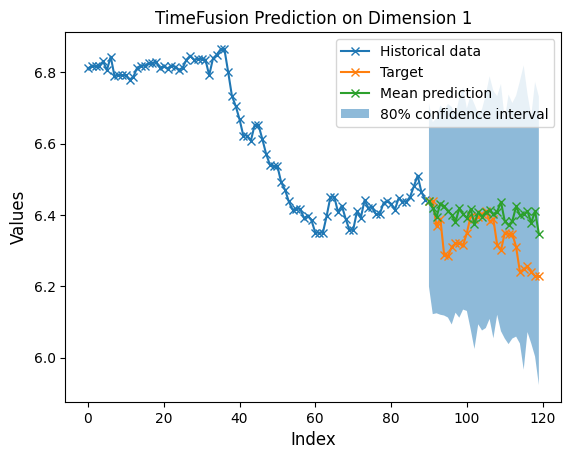

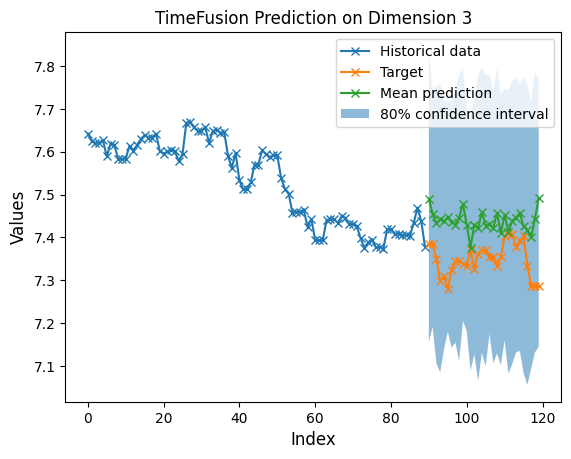

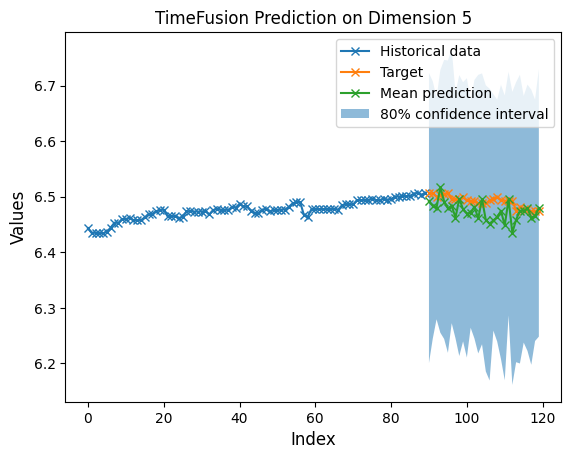

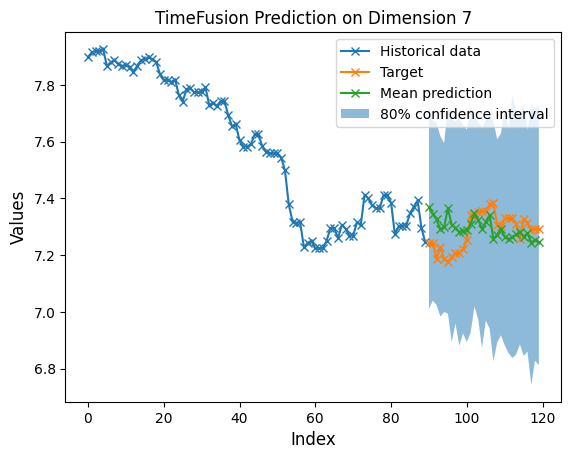

In [13]:
# Sample from model
last_idx = val_dataset.tensor_data.shape[0] - prediction_length - context_length
indices = [last_idx]
max_anchors = []
min_anchors = []
for idx in indices:
    off_idx = idx + context_length
    max_values = full_data.loc[full_data.index < val_data.index[off_idx]].max(axis=0)
    min_values = full_data.loc[full_data.index < val_data.index[off_idx]].min(axis=0)
    mean_values = full_data.loc[full_data.index < val_data.index[off_idx]].mean(axis=0)
    max_anchors.append(1.1*torch.tensor(max_values,dtype=torch.float32,device=device) - 0.1*torch.tensor(mean_values,dtype=torch.float32,device=device))
    min_anchors.append(1.1*torch.tensor(min_values,dtype=torch.float32,device=device) - 0.1*torch.tensor(mean_values,dtype=torch.float32,device=device))

max_anchors = torch.stack(max_anchors)
min_anchors = torch.stack(min_anchors)
anchors = torch.stack([min_anchors,max_anchors],dim = -1).unsqueeze(2).repeat((1,1,prediction_length,1))

samples = predictor.sample(
    data = val_dataset,
    indices = indices,
    prediction_length = prediction_length,
    num_samples = 128,
    batch_size = 128,
    anchors=anchors,
    anchor_strength=0.03,
)
samples = samples.cpu()

# Sort samples in ascending order
samples = samples.permute(0,2,3,1).flatten(start_dim=0,end_dim=2).sort()[0].reshape(samples.shape[0],samples.shape[2],samples.shape[3],-1).permute(0,3,1,2)

# Plot some predictions
confidence = 0.9

for ts in [1,3,5,7]:
    plt.figure()
    plt.title(f"TimeFusion Prediction on Dimension {ts}")
    plt.plot(val_dataset.tensor_data[indices[0] - (3*prediction_length - context_length):indices[0] + context_length,ts],"-x")
    plt.plot(list(range(3*prediction_length,4*prediction_length)),val_dataset.tensor_data[indices[0] + context_length:indices[0] + context_length+prediction_length,ts],"-x")
    plt.plot(list(range(3*prediction_length,4*prediction_length)),torch.mean(samples[0,:,ts],dim = 0),"-x")
    plt.fill_between(list(range(3*prediction_length,4*prediction_length)), samples[0,int(confidence*samples.shape[1]),ts], samples[0,int((1-confidence)*samples.shape[1]),ts],alpha=0.5)
    plt.legend(["Historical data","Target","Mean prediction","80% confidence interval"])
    plt.xlabel("Index",fontsize=12)
    plt.ylabel("Values",fontsize=12)
    plt.savefig(f"images/exchange_{ts}.png")
